# HW4: Building an AI Game Master

*Author: Andrew Zhu (andrz@seas.upenn.edu)*

In this homework, we'll use Kani to build a simple Game Master (GM) for the [Mausritter TTRPG](https://losing-games.itch.io/mausritter). Your GM will help walk you through creating a mouse and rolling dice to overcome challenges in the game. Along the way, you'll learn the basics of the [Kani library](https://kani.readthedocs.io/en/latest/), function calling with LLMs, and how a LLM can use structured information to act as a game state manager.

We won't implement more complex systems like combat or spellcasting in this homework, but extending this system to make a more comprehensive GM (e.g. adding inventory tracking, combat, spellcasting, structured tracking of NPCs, ...) would make for a great class final project.

## What You'll Need

- A copy of the [Mausritter rules](https://losing-games.itch.io/mausritter) (available for free on itch.io)
- Your [Helicone key](https://www.helicone.ai/developer)
- Recommended: the [Kani documentation](https://kani.readthedocs.io/en/latest/)
- Optional: the [d20 documentation](https://d20.readthedocs.io/en/latest/start.html)

# Part 0: Setup

*Reference: [Installation (Kani Documentation)](https://kani.readthedocs.io/en/latest/install.html)*

First, let's install the libraries we're using and configure Kani to use the Helicone proxy. Kani requires Python 3.10 or higher - if you encounter an error saying "No matching distribution found", you may need to upgrade your Python version.

## Virtual Environment

Before we get started, I recommend setting up a virtual environment for this homework. To set up a virtual environment, use the following terminal commands:

Mac/Linux:
```shell
python3.10 -m venv ./venv
./venv/bin/activate
pip install jupyter
```

Windows:
```shell
python3.10 -m venv venv
venv\Scripts\activate.bat
pip install jupyter
```

You may need to restart your IDE after creating a new virtual environment for it to detect the interpreter. Now, when we install dependencies, it won't affect the global environment.

## Line Wrapping

If you're using VSCode, you may want to enable word wrap for your notebook so long outputs on a single line automatically fold to multiple lines. You can find the wordwrap option by clicking on the gear icon in the upper right hand corner of your .ipynb file, then click "Customize Notebook Layout", then scroll down to the bottom of the settings and select "Notebook Output Word Wrap".

In [35]:
# Install dependencies
!pip install -q d20 'kani[openai]' openai

  Cloning https://github.com/zhudotexe/kani.git (to revision feat/chat-in-terminal-improvements) to /private/var/folders/0m/x9z2k6zn6cbgmyyfd94nmk300000gn/T/pip-install-j4r4d8gd/kani_dece095d858b4808ae8971eea4bafa38
  Running command git clone --filter=blob:none --quiet https://github.com/zhudotexe/kani.git /private/var/folders/0m/x9z2k6zn6cbgmyyfd94nmk300000gn/T/pip-install-j4r4d8gd/kani_dece095d858b4808ae8971eea4bafa38
  Running command git checkout -b feat/chat-in-terminal-improvements --track origin/feat/chat-in-terminal-improvements
  Switched to a new branch 'feat/chat-in-terminal-improvements'
  branch 'feat/chat-in-terminal-improvements' set up to track 'origin/feat/chat-in-terminal-improvements'.
  Resolved https://github.com/zhudotexe/kani.git to commit 6fe43a198952c8dc048decce6868c786d8a2e6a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached d20-1.1.2-py3-none-any.whl.metadata

We'll use GPT-4 as our LLM of choice, so we'll configure it as our *engine* (a Kani concept used to provide a standard interface to a LLM).

<div>
<img src="https://kani.readthedocs.io/en/latest/_images/concepts-figure.png" width="700"/>
</div>

To save you money with all of your prompting to GPT-4, you can use the Helicone account for the class. You should set your Helicone API Key (which you can find [here](https://www.helicone.ai/developer)) on the terminal with the command `export HELICONE_API_KEY=sk-helicone-cp-###########`. If you're using VS Code, you can launch it from your terminal with the `code` command and prefix it with this export statement on the same line. For example:

```
cd your/homework/dir
source venv/bin/activate
HELICONE_API_KEY=sk-helicone-cp-###########  code .
```

Alternatively, you can enter it by running the next cell. For more information on using the Helicone proxy, see [this Ed post](https://edstem.org/us/courses/50468/discussion/4413041).

We'll use the `engine` global throughout the rest of this homework.

In [1]:
import os
from getpass import getpass

# Set up your Helicone API key here
if "HELICONE_API_KEY" not in os.environ:
    print("You didn't set your Helicone key to the HELICONE_API_KEY env var on the command line.")
    os.environ["HELICONE_API_KEY"] = getpass("Please enter your Helicone API Key now: ")

You didn't set your Helicone key to the HELICONE_API_KEY env var on the command line.


In [2]:
# Set up a GPT-4 engine using the Helicone proxy
from kani.engines.openai import OpenAIEngine

engine = OpenAIEngine(api_key=os.environ["HELICONE_API_KEY"], model="gpt-4", api_base="https://oai.hconeai.com/v1")

# Part 1: Dice Rolling & Function Calling

First, let's get familiar with the libraries we're going to use. 

## 1.1: Dice Rolling

To implement dice rolling, we'll use `d20`, a Python dice library I wrote for D&D. This library parses RPG dice notation and rolls the specified dice. For this homework, we'll use its output as Markdown, but if you're interested in a deeper dive into the library, the output is a [structured eval tree](https://d20.readthedocs.io/en/latest/expression.html).

Mausritter uses standard RPG dice notation throughout.

For example:
- `d20` means: Roll a single 20-sided die
- `1d8` means: Roll a single 8-sided die
- `3d6` means: Roll three 6-sided dice, add them together

In certain circumstances, you'll need to roll some dice and keep only the N highest (e.g. 4d6, keep highest 3). `d20` expresses this in "keep-highest" notation:

- `4d6kh3` means: Roll four six-sided dice, add the highest three together
- `2d20kl1` means: Roll two d20s, keep the lower ("disadvantage" in D&D, "advantage" in Mausritter)

For more examples, check out [the documentation](https://d20.readthedocs.io/en/latest/start.html#examples). Try running this cell a couple times to see what the result of these rolls are! Feel free to add more rolls to experiment, too.

In [3]:
from d20 import roll

print(roll("d20"))
print(roll("1d8"))
print(roll("3d6"))
print(roll("4d6kh3"))
print(roll("2d20kl1"))

1d20 (14) = `14`
1d8 (**1**) = `1`
3d6 (2, **6**, 5) = `13`
4d6kh3 (2, **6**, ~~**1**~~, 3) = `11`
2d20kl1 (~~19~~, 18) = `18`


In [4]:
# d20 can also handle basic math:
print(roll("2d6 * 3"))
print(roll("1d6 * 10 + 1d6"))

2d6 (3, 4) * 3 = `21`
1d6 (4) * 10 + 1d6 (**1**) = `41`


The `roll()` function returns a `RollResult` object, which contains the stringified roll (`RollResult.result`), its numeric total (`RollResult.total`), and the eval tree. You can use this, for example, to roll stats for a mouse!

Mausritter defines your mouse's stats as such:

> For each attribute, in order, roll 3d6. Keep the two highest dice results for a value between 2—12.

To make sure you understand how to use d20, let's this into a roll statement for one attribute, and print the result and final rolled total here.

In [ ]:
# TODO: roll one attribute and print its roll and value
attr_result = roll("...")
print(...)
print(...)

## 1.2: Function Calling

*Reference: [Function Calling (Kani Documentation)](https://kani.readthedocs.io/en/latest/function_calling.html)*

Now, let's give a LLM the ability to roll dice! With Kani, you can write functions in Python and expose them to the model with just one line of code: the `@ai_function` decorator.

To create a kani with function calling, make a subclass of Kani and write your functions as methods. In order for a language model to effectively know what our AI functions do, we need to document them. We do this inline in the function: through type annotations and the docstring.

The allowed types are:

- Python primitive types (`None`, `bool`, `str`, `int`, `float`)
- an enum (`enum.Enum`)
- a list or dict of the above types (e.g. `list[str]`, `dict[str, int]`, `list[SomeEnum]`)

When the AI calls into the function, kani validates the AI’s requested parameters and guarantees that the passed parameters are of the annotated type by the time they reach your code.

By default, the function’s description will be taken from its docstring, and name from the source.

To specify the descriptions of parameters, you can provide an AIParam annotation using a `typing.Annotated` type annotation.

For example, you might annotate a parameter `timezone: str` with an example, like `timezone: Annotated[str, AIParam("The IANA time zone, e.g. America/New_York")]`.

Let's use this to expose the `roll()` function to GPT-4. Your method should take in the dice as a string, and return the resulting Markdown roll to the model.

In [5]:
from kani import Kani, ai_function, ChatMessage


class DiceKani(Kani):
    @ai_function()
    def roll(
        self,
        # TODO: add a parameter to this method to tell the model what to pass to it
    ):
        """
        TODO: Add documentation to this method to tell the model how to use it
        HINT: Try giving the model examples, or telling it to use RPG notation
        """
        # TODO: roll the dice provided by the model and return the result to it
        result = ...
        return result

In [6]:
# SOLUTION
class DiceKani(Kani):
    @ai_function()
    def roll(self, dice: str):
        """
        Roll some dice. Accepts D&D-style RPG notation and standard arithmetic operations.
        Examples:
        d20
        1d8
        4d6kh3
        2d6 * 3
        2d20kl1
        1d6 * 10 + 1d6
        """
        return str(roll(dice))


# END SOLUTION

Now, let's create an instance of your Kani with dice rolling and ask it to roll dice. In addition to standard queries like "roll me 4d6," an LLM can translate more complex queries from natural language to RPG dice syntax. Try asking it to roll an attribute for a mouse using Mausritter's natural language description, or even something that relies on background knowledge, like damage for a fireball spell.

To exit the chat session, send the word `!stop`.

In [7]:
from kani import chat_in_terminal

dice_ai = DiceKani(engine)
chat_in_terminal(dice_ai, stopword="!stop", verbose=True)

USER: roll me damage for a 3rd level fireball in D&D
AI: Thinking... [roll(dice='8d6')]
FUNC: 8d6 (**6**, 5, 5, 4, **1**, **1**, 2, **1**) = `25`
AI: The damage for a 3rd level fireball in D&D is `25`.
USER: !stop


Easy, right? You can add more functions easily by defining more methods in your Kani subclass, and implement complex logic in the function body too. Let's use this to do something a little more complex: creating a character.

# Part 2: Character Creation

*Reference: Mausritter rulebook, pg. 8; [Function Calling (Kani Documentation)](https://kani.readthedocs.io/en/latest/function_calling.html)*

Before we get started playing Mausritter, you need to make a mouse! Luckily, making a mouse is easy: just roll for stats, background, and details. We'll record the equipment your mouse starts with in this homework, but won't implement a full structured inventory system (unless you are doing an extension).

## 2.1: Character Creator Agent

Let's build an AI agent to help walk us through character creation. Since character creation is fairly algorithmic, it's possible to write a character generator (like the one at https://mausritter.com/mouse/) without the use of an LLM at all - but in this homework, we'll use GPT-4 to parse the rules and output a mouse, ready to go.

First, let's define the goal: your agent should output a `Mouse` as defined here. Each of the structured character attributes matches those defined in the Mausritter rules, and we'll also add a LLM-generated prose description of your mouse.


In [3]:
import dataclasses
from dataclasses import dataclass


@dataclass
class Mouse:
    # structured character attributes
    strength: int
    dexterity: int
    will: int
    hp: int
    pips: int
    background: str
    birthsign: str
    disposition: str
    coat: str
    physical_detail: str
    name: str

    # LLM-generated
    description: str = ""


# Here's an example Mouse:
horatio = Mouse(
    name="Horatio Seedfall",
    background="Ale brewer",
    strength=11,
    dexterity=10,
    will=8,
    hp=2,
    birthsign="Wheel",
    disposition="Industrious / Unimaginative",
    coat="Chocolate, flecked",
    physical_detail="Tiny body",
    pips=3,
    description=(
        'Horatio Seedfall, more commonly known as "Ale Brewer" in his local mouse village, is a pint-sized powerhouse.'
        " His fur, a rich chocolate hue speckled with an array of lighter flecks, is reminiscent of the fine, roasted"
        " barley he uses in his brewing. His small size might deceive the unassuming observer, but beneath that tiny"
        " body of his lies a heart as tenacious as a bear's."
    ),
)

Now, we'll define a subclass of the `DiceKani` we made in part 1. This means that this Kani will also have access to roll dice!

You have a lot of freedom on how to implement the mouse creator here. Maybe you'll add functions to roll on each of the tables in the rulebook? Maybe you'll generate your mouse's background and other story attributes using the tables only for inspiration? Maybe you'll be able to simply prompt GPT-4 with the mouse creation instructions?

Remember, we aren't tracking inventory in this homework in the structured JSON (unless you are doing an extension), so you don't need to generate structured data regarding items. **You should have the LLM write down what items come with your mouse's background in their prose description, though.**

Regardless of the approach you choose, your Kani should call the provided `make_mouse` function at least once. This function shows how you can use function calling to make GPT-4 output a fairly large amount of structured data by presenting the desired data format as function parameters.

In [ ]:
class MouseCreatorKani(DiceKani):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mouse = None

    # TODO: add additional ai_functions here if needed
    # e.g. roll_attribute, lookup_background, roll_birthsign, generate_description, etc.

    # your Kani should call this at least once and output a valid mouse!
    # this parses the parameters GPT-4 generates and passes them to the Mouse constructor,
    # then saves them to an instance attribute so we can use the created Mouse later
    @ai_function()
    def make_mouse(
        self,
        # TODO: Modify the types of the parameters of this method to add model prompting if needed
        strength: int,
        dexterity: int,
        will: int,
        hp: int,
        pips: int,
        background: str,
        birthsign: str,
        disposition: str,
        coat: str,
        physical_detail: str,
        name: str,
        description: str,
    ):
        """
        TODO: Add documentation to this method to tell the model how to use it
        """
        self.mouse = Mouse(
            strength=strength,
            dexterity=dexterity,
            will=will,
            hp=hp,
            pips=pips,
            background=background,
            birthsign=birthsign,
            disposition=disposition,
            coat=coat,
            physical_detail=physical_detail,
            name=name,
            description=description,
        )
        # TODO: Tell GPT-4 that you successfully created or updated the mouse
        return "..."

You can add additional prompting here to tell the agent how to use your provided functions (e.g. a high-level flow).

In [ ]:
# TODO: instruct GPT-4 on how to call the functions you provided to it to create a mouse.
# Not sure where to start? Try giving it the whole mouse creation rules
MOUSE_CREATOR_PROMPT = """
...
"""

In [ ]:
# SOLUTION
class MouseCreatorKani(DiceKani):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mouse = None

    @ai_function()
    def make_mouse(
        self,
        strength: int,
        dexterity: int,
        will: int,
        hp: int,
        pips: int,
        background: str,
        birthsign: str,
        disposition: str,
        coat: str,
        physical_detail: str,
        name: str,
        description: str,
    ):
        """
        When you have collected all the details about the mouse from the user, call this function to save the character.
        """
        self.mouse = Mouse(
            strength=strength,
            dexterity=dexterity,
            will=will,
            hp=hp,
            pips=pips,
            background=background,
            birthsign=birthsign,
            disposition=disposition,
            coat=coat,
            physical_detail=physical_detail,
            name=name,
            description=description,
        )
        return "Mouse created successfully!"


MOUSE_CREATOR_PROMPT = """
These are the instructions to make a mouse for the Mausritter RPG:

The world is very big and very dangerous for a small
mouse adventurer. You will need to be very brave, and
always keep your wits about you.
1. Attributes
Your mouse has three attribute scores. These measure
their basic strengths and weaknesses.
• STR: physical strength and resilience.
• DEX: speed and agility.
• WIL: strength of will and charisma.
For each of these attributes, in order, roll 3d6.
Keep the two highest dice results for a value between 2—12.
You may then swap any two attributes.
2. HP, pips and background
Roll d6 for your Hit Protection (HP). This is the damage
your mouse can shrug off before taking serious harm.
Roll d6 for your mouse’s starting pips. These are the
basic currency of the mouse kingdom.
Cross reference the value of your HP with your pips
on the Background table. This is what your mouse was
before becoming an adventurer.
3. Details
Roll or choose birthsign, coat and a physical detail.
Choose a name appropriate for a brave mouse.

Birthsign
d6 Sign Disposition
1 Star Brave / Reckless
2 Wheel Industrious / Unimaginative
3 Acorn Inquisitive / Stubborn
4 Storm Generous / Wrathful
5 Moon Wise / Mysterious
6 Mother Nurturing / Worrying

Coat
d6 Color d6 Pattern
1 Chocolate 1 Solid
2 Black 2 Brindle
3 White 3 Patchy
4 Tan 4 Banded
5 Grey 5 Marbled
6 Blue 6 Flecked

Physical detail
d66 Details
11 Scarred body 41 Groomed fur
12 Corpulent body 42 Dreadlocks
13 Skeletal body 43 Dyed fur
14 Willowy body 44 Shaved fur
15 Tiny body 45 Frizzy fur
16 Massive body 46 Silky fur
21 War paint 51 Night black eyes
22 Foreign clothes 52 Eye patch
23 Elegant clothes 53 Blood red eyes
24 Patched clothes 54 Wise eyes
25 Fashionable clothes 55 Sharp eyes
26 Unwashed clothes 56 Luminous eyes
31 Missing ear 61 Cropped tail
32 Lumpy face 62 Whip-like tail
33 Beautiful face 63 Tufted tail
34 Round face 64 Stubby tail
35 Delicate face 65 Prehensile tail
36 Elongated face 66 Curly tail
Tip: d66 means d6 x 10 + d6

Backgrounds
HP Pips Background Item A Item B
1 1 Test subject Spell: Magic missile Lead coat (Heavy armour)
1 2 Kitchen forager Shield & jerkin (Light armour) Cookpots
1 3 Cage dweller Spell: Be understood Bottle of milk
1 4 Hedge witch Spell: Heal Incense stick
1 5 Leatherworker Shield & jerkin (Light armour) Shears
1 6 Street tough Dagger (Light, d6) Flask of coffee
2 1 Mendicant priest Spell: Restore Holy symbol
2 2 Beetleherd Hireling: Loyal beetle Pole, 6"
2 3 Ale brewer Hireling: Drunken torchbearer Small barrel of ale
2 4 Fishermouse Net Needle (Light, d6)
2 5 Blacksmith Hammer (Medium, d6/d8) Metal file
2 6 Wireworker Wire, spool Electric lantern
3 1 Woodcutter Axe (Medium, d6/d8) Twine, roll
3 2 Bat cultist Spell: Darkness Bag of bat teeth
3 3 Tin miner Pickaxe (Medium, d6/d8) Lantern
3 4 Trash collector Trashhook (Heavy, d10) Mirror
3 5 Wall rover Fishhook Thread, spool
3 6 Merchant Hireling: Pack rat 20p IOU from a noblemouse
4 1 Raft crew Hammer (Medium, d6/d8) Wooden spikes
4 2 Worm wrangler Pole, 6" Soap
4 3 Sparrow rider Fishhook Goggles
4 4 Sewer guide Metal file Thread, spool
4 5 Prison guard Chain, 6" Spear (Heavy, d10)
4 6 Fungus farmer Dried mushroom (as rations) Spore mask
5 1 Dam builder Shovel Wooden spikes
5 2 Cartographer Quill & ink Compass
5 3 Trap thief Block of cheese Glue
5 4 Vagabond Tent Treasure map, dubious
5 5 Grain farmer Spear (Heavy, d10) Whistle
5 6 Message runner Bedroll Documents, sealed
6 1 Troubadour Musical instrument Disguise kit
6 2 Gambler Set of loaded dice Mirror
6 3 Sap tapper Bucket Wooden spikes
6 4 Bee keeper Jar of honey Net
6 5 Librarian Scrap of obscure book Quill & ink
6 6 Pauper noblemouse Felt hat Perfume

Walk me through making a mouse, then save my mouse by calling `make_mouse()`.
"""
# END SOLUTION

Finally, chat with your agent and make a mouse! We'll use your mouse in the last part to play a small game of Mausritter.

In [ ]:
# Run this cell to reset the state of your mouse creator
mouse_creator_ai = MouseCreatorKani(engine, always_included_messages=[ChatMessage.user(MOUSE_CREATOR_PROMPT)])

In [ ]:
import time

# You can rerun this cell to continue conversation with your mouse creator
# Send "!stop" when you are done making your mouse
chat_in_terminal(mouse_creator_ai, stopword="!stop", verbose=True)
mouse_creator_ai.save(f"creator-{int(time.time())}.json")

Let's retrieve your mouse and print them here, to make sure everything saved correctly. Let's also save it to a JSON file in case you rerun this notebook and want to continue from here.

In [ ]:
import json

my_mouse = mouse_creator_ai.mouse
mouse_dict = dataclasses.asdict(my_mouse)

with open("my-character.json", "w") as f:
    json.dump(mouse_dict, f)

mouse_dict

In [4]:
import json

# To load a saved mouse, run this cell
with open("my-character.json") as f:
    mouse_dict = json.load(f)
my_mouse = Mouse(**mouse_dict)

If all goes well, you now have a mouse to play with! In the cell below, write down your high-level approach to the character creator -- e.g. did you give the model flexible control over the process or strict step-by-step instructions -- and any insights you learned while iterating on the agent.

Some things you could mention: Do you think a player who's never played a TTRPG before could create a mouse using your character creator by chatting with your agent and asking questions where they don't understand? How might you implement this agent in part of a larger system?

In the next part, we'll make a Kani that can roll checks and saves, and play a small game of Mausritter.

In [ ]:
CHARACTER_CREATOR_INSIGHTS = """
TODO: Add your thoughts here
"""

## 2.2: Use DALL-E to generate a character portrait

*Reference: [Images (OpenAI Documentation)](https://platform.openai.com/docs/api-reference/images)*

Now we've generated a structured representation of your mouse and a prose description of what they look like, but can we turn this collection of attributes into an image? Let's use DALL-E 3 to generate a portrait of your mouse!

You'll need to use your personal OpenAI account for this, as Helicone cannot proxy image generation requests. It costs $0.04-$0.12 to generate one image with DALL-E 3, depending on the resolution and quality settings (https://openai.com/pricing). Run the next cell to set up your personal OpenAI API key.

In [6]:
import os

if "OPENAI_API_KEY" not in os.environ:
    print("You didn't set your OpenAI key to the OPENAI_API_KEY env var on the command line.")
    os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API Key now: ")

In [7]:
import httpx
from openai import OpenAI

# create the OpenAI client
dalle_client = OpenAI()
http = httpx.Client()

This code cell defines what you'll need to call the DALL-E API. It provides the `generate_image(prompt)` function which will call the Generate Image endpoint and download the generated image.

DALL-E 3 will also revise the prompt you provide to it by default, augmenting it with more synthetic details like we did in HW3. This can often help the model generate higher-fidelity images, but can also introduce weird hallucinations into the final image. The `generate_image` function will print out both the original prompt and its revision as sent to the image generation model.

In [19]:
import re
from IPython.display import Image, display

# make a folder to save generated images
os.makedirs("dalle", exist_ok=True)

def make_safe_filename(name, ext=".png"):
    """Ensure that a filename is safe to save to disk (replace any non-alphanumeric characters with an underscore)."""
    name = re.sub(r"[^a-zA-Z0-9-]+", "_", name)
    name = name[:100]
    return f"{name}{ext}"


def generate_image(prompt, size="1024x1024"):
    """Generate an image, save it to disk, and display it.

    Returns a dict {"image_path": "...", "original_prompt": "...", "revised_prompt": "..."}.
    """

    # generate the image using the OpenAI API
    resp = dalle_client.images.generate(
        prompt=prompt,
        model="dall-e-3",
        response_format="url",
        quality="hd",  # feel free to change to "standard" for some cost savings
        size=size,  # also try "1024x1792" for portrait or "1792x1024" for landscape
        style="vivid",  # "vivid" or "natural"
    )
    image = resp.data[0]

    # download the generated image from URL (expires after 60m)
    fp = f"dalle/{make_safe_filename(image.revised_prompt)}"
    with open(fp, "wb") as f:
        with http.stream("GET", image.url) as r:
            for data in r.iter_bytes():
                f.write(data)

    # show the prompt, DALL-E rewrite, and the image
    print("Original prompt:", prompt)
    print()
    print("Revised prompt:", image.revised_prompt)
    print()
    print(f"Saved to {fp}")
    display(Image(fp, width=500, height=500))

    return {"image_path": fp, "original_prompt": prompt, "revised_prompt": image.revised_prompt}

Now it's up to you to generate an image for your mouse you created in part 2.1. You could manually write a prompt, create a template based off the structured attributes you have available, or create a new Kani agent to write prompts for you! Whichever you choose, please describe your approach below.

In [9]:
# TODO: Use generate_image() to create a portrait for your mouse

In [10]:
# TODO: What approach did you use to create prompts for DALL-E? What strengths and weaknesses does this approach have? If you tried multiple approaches, how do they compare?
DALLE_APPROACHES = """
...
"""

Original prompt: The portrait of a mouse adventurer in the style of a medieval tapestry. They have a marbled coat and a groomed fur. A common motif for them is the Moon, and they are a bat cultist. They have a bag of bat teeth and the ability to cast Darkness.

Revised prompt: Create an image of a mouse adventurer as depicted in a medieval tapestry. This daring rodent has a marbled coat and meticulously groomed fur. A frequent symbolism linked to this mouse is the Moon, suggesting their allegiance to a cult of bats. In their possession, they carry a bag full of bat teeth, a grim memento of past exploits. With the awe-inspiring ability to cast Darkness, our diminutive hero is a bewitching sight to behold. The tale of this adventuring mouse enchants the viewer as it unfolds across the intricately woven fabric of the tapestry.

Saved to dalle/Create_an_image_of_a_mouse_adventurer_as_depicted_in_a_medieval_tapestry_This_daring_rodent_has_a_ma.png


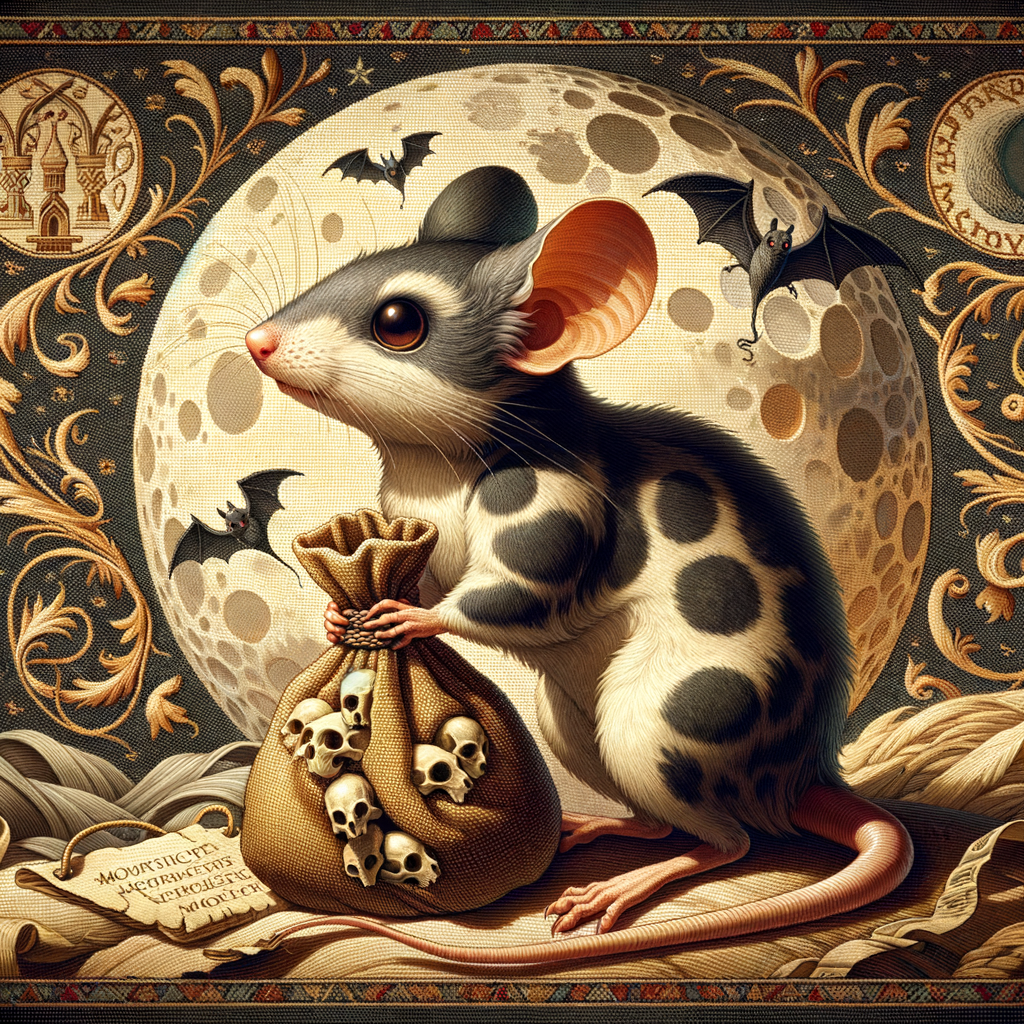

{'image_path': 'dalle/Create_an_image_of_a_mouse_adventurer_as_depicted_in_a_medieval_tapestry_This_daring_rodent_has_a_ma.png',
 'original_prompt': 'The portrait of a mouse adventurer in the style of a medieval tapestry. They have a marbled coat and a groomed fur. A common motif for them is the Moon, and they are a bat cultist. They have a bag of bat teeth and the ability to cast Darkness.',
 'revised_prompt': 'Create an image of a mouse adventurer as depicted in a medieval tapestry. This daring rodent has a marbled coat and meticulously groomed fur. A frequent symbolism linked to this mouse is the Moon, suggesting their allegiance to a cult of bats. In their possession, they carry a bag full of bat teeth, a grim memento of past exploits. With the awe-inspiring ability to cast Darkness, our diminutive hero is a bewitching sight to behold. The tale of this adventuring mouse enchants the viewer as it unfolds across the intricately woven fabric of the tapestry.'}

In [30]:
# SOLUTION
dalle_client.organization = "org-dxkPAvuWroRmYw7z0VhqMC5S"

# generate_image(
#     "Generate a portrait for my character in the Mausritter sword-and-whiskers RPG. They are a mouse adventurer that"
#     f" is {'strong' if my_mouse.strength > 7 else 'weak'}, {'agile' if my_mouse.dexterity > 7 else 'clumsy'}, and"
#     f" {'strong-minded' if my_mouse.will > 7 else 'weak-minded'}. They have a {my_mouse.coat} coat and a"
#     f" {my_mouse.physical_detail}. A common motif for them is the {my_mouse.birthsign}, and they are a"
#     f" {my_mouse.background}. They have a set of loaded dice and a mirror. Do not include any text."
# )

# and a couple of manual prompts to play with
generate_image(
    "The portrait of a mouse adventurer in the style of a medieval tapestry. They have a marbled coat and a"
    f" groomed fur. A common motif for them is the Storm, and they are a"
    f" bee keeper. They have a jar of honey and a net.",
    size="1024x1024"
)

# generate_image(
#     "The portrait of a mouse adventurer in the style of a fantasy illustration. They have a blue coat and"
#     f" war paint. A common motif for them is the Moon, and they are a"
#     f" bat cultist. They have a bag of bat teeth and the ability to cast Darkness. Do not include any text.",
#     size="1024x1792"
# )
# END SOLUTION

# Part 3: Playing the Game

*Reference: Mausritter rulebook, pg. 12 & pg. 18*

Finally, let's make a GM Kani! If you're familiar with [AI Dungeon](https://aidungeon.com/), the concept here is similar: the model will act as our GM, defining the world and challenges in it. Unlike AI Dungeon, though, we have a character that we created and the ability to roll based off that character sheet!

Let's implement Saves (Mausritter p. 12):

> When you describe your mouse doing something risky where the outcome is uncertain and failure has consequences, the GM will ask you to make a save against either STR, DEX or WIL.
> To make a save, roll a d20. If the result is less than or equal to the relevant attribute, your mouse succeeds, and suffers no consequences. If the result is over the attribute, your mouse fails, and suffers the consequences described by the GM.

Again, we'll make a Kani that subclasses our DiceKani in part 1. You should implement the `roll_save` method that takes in the stat and if the roll is at advantage or disadvantage, and returns whether or not the save was successful.

In [ ]:
class MausritterKani(DiceKani):
    # This Kani should reference your mouse - let's pass it in the constructor.
    def __init__(self, *args, mouse: Mouse, **kwargs):
        super().__init__(*args, **kwargs)
        self.mouse = mouse

    @ai_function()
    def roll_save(
        self,
        # TODO: add necessary parameters
    ):
        """TODO: describe this method for the LLM"""
        # TODO: roll a save for the given stat, compare it to your mouse's stats, and tell the LLM if you succeed or fail
        return ...

In [ ]:
# TODO: instruct GPT-4 on how to call the functions you provided to it and high-level instructions to run the game.
# You should also include information on the character you created so the GM can reference it.
# Not sure where to start? Try telling it to introduce the world first.
# You might also want to look at the play example on pg. 18 of the Mausritter rulebook.
GM_PROMPT = """
...
"""

In [ ]:
# SOLUTION
import enum
import json


class SaveStat(enum.Enum):
    STR = "STR"
    DEX = "DEX"
    WIL = "WIL"


class MausritterKani(DiceKani):
    # This Kani should reference your mouse - let's pass it in the constructor.
    def __init__(self, *args, mouse: Mouse, **kwargs):
        super().__init__(*args, **kwargs)
        self.mouse = mouse

    @ai_function()
    def roll_save(
        self,
        stat: SaveStat,
        advantage: Annotated[
            int, AIParam("Whether the roll should be at advantage (1), disadvantage (-1), or neither (0).")
        ] = 0,
    ):
        """
        When the players describes their mouse doing something risky where the outcome is uncertain and failure has consequences, they will need to make a save against either STR, DEX or WIL.

        To make a save, call this function with the required stat. If the result is less than or equal to the relevant attribute, their mouse succeeds, and suffers no consequences. If the result is over the attribute, their mouse fails, and you should describe the consequences.
        """
        if stat == SaveStat.STR:
            target = self.mouse.strength
        elif stat == SaveStat.DEX:
            target = self.mouse.dexterity
        else:
            target = self.mouse.will

        if advantage == 1:
            adv_dice = "2d20kl1"
        elif advantage == -1:
            adv_dice = "2d20kh1"
        else:
            adv_dice = "1d20"

        save_result = roll(adv_dice)
        success_str = "SUCCESS" if save_result.total <= target else "FAILURE"
        return f"{save_result.result}: {success_str}"


GM_PROMPT = f"""
You are the game master for a game of Mausritter, a TTRPG where the player plays as a mouse.

>>> The mouse kingdoms survive on the edge of collapse.
A harsh winter or heartless cat could spell the end for
all. The settled mice huddle together, hidden in their
settlements in trees and burrows and walls, scraping and
saving. A tenuous existence.
But you are not like those settled mice.
By choice or by necessity you are an adventurer.
You live by your luck, your smarts, your bravery.
With your friends by your side, you will abandon the
warmth and safety of the mouse settlements and
venture forth into the dark and dangerous places where
other mice do not dare to tread.
There is great wealth to be found by those that are willing to take it. The world is old. Great empires of mouse
and beast have risen and fallen.
It's a huge and dangerous world out there. It does not
look kindly on a small mouse. But if you are very brave
and very clever and just a bit lucky, you might be able to
survive. And if you survive long enough, you might even
become a hero amongst mice.

The player is playing {my_mouse.name}. Their stats are:
```json
{json.dumps(dataclasses.asdict(my_mouse), indent=2)}
```

You should start by creating a world for the game, then introducing them to the setting you made. After that, act as the game master and take the player on an adventure!
"""
# END SOLUTION

In [ ]:
# Run this cell to reset the state of your game
# You can also add existing chat_history here if you'd like
gm_ai = MausritterKani(engine, mouse=my_mouse, system_prompt=GM_PROMPT)

Now, explore the world created by your model! When you're done, send `!stop`. The game transcript will be automatically saved to `gm.json`.

In [ ]:
# You can rerun this cell to continue the game
# Send "!stop" when you are done making your mouse
chat_in_terminal(gm_ai, stopword="!stop", verbose=True)
gm_ai.save(f"gm-{int(time.time())}.json")

## Structureless Comparison

Cool, isn't it? But is it really *better* to provide LLMs with this structured information and access to tools?

To answer this question, let's try playing without structure: only prompt GPT-4 to act as the GM WITHOUT access to your character sheet or dice rolling.

In [ ]:
# TODO: instruct GPT-4 on how to act as a Mausritter GM.
# You should NOT include information on function calling, but may tell it about your character (your choice).
GM_PROMPT_STRUCTURELESS = """
...
"""

In [ ]:
# We'll use an unmodified Kani here -- it won't have access to dice rolling.
gm_ai_structureless = Kani(engine, system_prompt=GM_PROMPT_STRUCTURELESS)

In [ ]:
# You can rerun this cell to continue the game
# Send "!stop" when you are done making your mouse
chat_in_terminal(gm_ai_structureless, stopword="!stop", verbose=True)
gm_ai_structureless.save(f"gm-structureless-{int(time.time())}.json")

Did you notice any significant difference in the gameplay in the short term? How about in the long term? Why do you think this might be? Could you think of any other functions you could expose to the GM to improve its story coherence over multiple play sessions? Write down your thoughts here.

In [ ]:
AI_GM_THOUGHTS = """
TODO: Write your thoughts here.
"""

That's it for HW4! Hopefully you've gained an understanding of how structured game state can influence LLMs, and how to use Kani with function calling to give LLMs powerful capabilities. These skills will come in handy as you begin working on your final projects!

## What you should submit

You should submit to Gradescope:
- this notebook with all TODOs and free-response sections completed
- the latest saved transcripts of your character creator agent and play (with a structured and unstructured AI GM)
- the image(s) you generated of your character

# Extension Ideas (for groups of 3+)

- Implement more of the Mausritter mechanics (e.g. inventory, NPCs, spells, or combat)
- Give your AI GM the ability to call `generate_image` to visualize the game as it's played